# Introduction to Convolutional Neural Networks and Computer Vision with Tensorflow

Computer vision is the practice of writing algorithms which can discover patterns in visual data. Such as the camera of a self driving car recognizing the car in front of it.

In [1]:
#Import sklearn before tensorflow
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
import os
import pathlib
import numpy as np
import random
import urllib.request

In [2]:
print(tf.__version__), sys.version, sklearn.show_versions()

2.4.1

System:
    python: 3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]
executable: C:\Users\timar\AppData\Local\Programs\Python\Python38\python.exe
   machine: Windows-10-10.0.19041-SP0

Python dependencies:
          pip: 21.0.1
   setuptools: 49.2.1
      sklearn: 0.24.1
        numpy: 1.19.5
        scipy: 1.6.2
       Cython: None
       pandas: 1.2.3
   matplotlib: 3.4.1
       joblib: 1.0.1
threadpoolctl: 2.1.0

Built with OpenMP: True
C:\Users\timar\AppData\Local\Programs\Python\Python38\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


(None,
 '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]',
 None)

# Test for Tensorflow GPU Support

GPU setup is documented here: https://www.tensorflow.org/install/gpu

In [3]:
tf.test.gpu_device_name(), tf.config.list_physical_devices('GPU')

('/device:GPU:0',
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [4]:
# See if we have a GPU
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("No GPU detected or you need to install the GPU version of tensorflow using pip install tensorflow-gpu.")

Default GPU Device:/device:GPU:0


# Download and Unzip the Data

* The source data set is from the [Kaggle Food 101 Data Set](https://www.kaggle.com/dansbecker/food-101)
* Daniel modified the data set [using this script](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb).
* The resulting zip file we use in this notbnook [is here](https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip).


In [5]:
#Setup variables for our data
if os.name == "nt":
    zip_download_file = "c:/temp/data/pizza_steak/pizza_steak.zip"
    zip_extract_location = "c:/temp/data/pizza_steak/"
    data_dir = "c:/temp/data/pizza_steak/pizza_steak"
else:
    zip_download_file = "/home/pi/Dev/data/pizza_steak/pizza_steak.zip"
    zip_extract_location = "/home/pi/Dev/data/pizza_steak/"
    data_dir = "/home/pi/Dev/data/pizza_steak/pizza_steak"

train_data_dir = data_dir + "/train"
test_data_dir = data_dir + "/test"

In [6]:
# Get the data set
# TODO: UNCOMMENT ME if you havent downloaded it yet
# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip -O $zip_download_file


In [7]:
# Unzip the data
# Get the data set
# TODO: UNCOMMENT ME if you havent downloaded and unzipped it yet
#import zipfile
#zip_ref = zipfile.ZipFile(zip_download_file)
#zip_ref.extractall(path=zip_extract_location)
#zip_ref.close()


# Inspect the Data

A very crucial step at the beginning of any machine learning project is becoming one with the data.

And for a computer vision project this usually means visualizing many samples of your data.

In [8]:

!ls -la $data_dir

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
!ls -la $data_dir/train

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [10]:
!ls -la $data_dir/train/steak

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
# Walk through pizza_steak directory and list number of files
# The extra file in our pizza_steak directory is .DS_Store
for dirpath, dirnames, filenames in os.walk(data_dir):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}.")

There are 2 directories and 1 images in c:/temp/data/pizza_steak/pizza_steak.
There are 2 directories and 1 images in c:/temp/data/pizza_steak/pizza_steak\test.
There are 0 directories and 250 images in c:/temp/data/pizza_steak/pizza_steak\test\pizza.
There are 0 directories and 250 images in c:/temp/data/pizza_steak/pizza_steak\test\steak.
There are 2 directories and 1 images in c:/temp/data/pizza_steak/pizza_steak\train.
There are 0 directories and 750 images in c:/temp/data/pizza_steak/pizza_steak\train\pizza.
There are 0 directories and 750 images in c:/temp/data/pizza_steak/pizza_steak\train\steak.


In [12]:
 # Another way to find out how many images are in a directory
 num_steak_images_train = len(os.listdir(data_dir+"/train/steak"))
 num_steak_images_train

750

# Visualize our Images

In [13]:
train_data_dir_path = pathlib.Path(train_data_dir)
for item in train_data_dir_path.glob("*"):
    print(item)

c:\temp\data\pizza_steak\pizza_steak\train\.DS_Store
c:\temp\data\pizza_steak\pizza_steak\train\pizza
c:\temp\data\pizza_steak\pizza_steak\train\steak


In [14]:
# To visualize our imaages, first lets get our class names programatically
train_data_dir_path = pathlib.Path(data_dir+"/train/")
# Create a list of class names from the subdirectories
class_names = np.array(sorted([item.name for item in train_data_dir_path.glob("*")]))
class_names = np.delete(class_names, np.where(class_names == ".DS_Store"))
print(class_names)


['pizza' 'steak']


In [15]:
# Lets visualize our images
def view_random_image(target_dir, target_class):
    # Setup the target directory (we'll view images from here)
    target_folder = target_dir + "/" + target_class
    
    #Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)
    
    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.xlabel(f"File: {random_image[0]}, Shape: {img.shape}")

    print(f"Image Shape: {img.shape}")
    return img



Image Shape: (512, 512, 3)


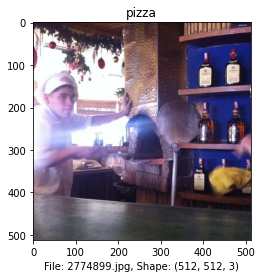

In [16]:
# View a random image from the training data set
img = view_random_image(train_data_dir, "pizza")

# Preprocess our Images

In [17]:
tf.constant(img)

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[45, 31, 46],
        [38, 24, 39],
        [38, 26, 40],
        ...,
        [25, 25, 49],
        [26, 26, 52],
        [26, 26, 52]],

       [[46, 32, 47],
        [43, 29, 44],
        [42, 30, 44],
        ...,
        [24, 24, 48],
        [24, 24, 50],
        [23, 23, 49]],

       [[43, 31, 43],
        [45, 33, 45],
        [44, 32, 44],
        ...,
        [30, 28, 52],
        [29, 26, 53],
        [28, 25, 52]],

       ...,

       [[86, 86, 86],
        [88, 88, 88],
        [87, 87, 87],
        ...,
        [49, 50, 54],
        [48, 49, 53],
        [40, 41, 45]],

       [[81, 81, 81],
        [83, 83, 83],
        [84, 84, 84],
        ...,
        [50, 51, 55],
        [48, 49, 53],
        [44, 45, 49]],

       [[82, 82, 82],
        [82, 82, 82],
        [84, 84, 84],
        ...,
        [44, 45, 49],
        [42, 43, 47],
        [43, 44, 48]]], dtype=uint8)>

In [18]:
# View the image shape
img.shape

(512, 512, 3)

# Build the CNN End to End Eample

Lets build a convolutional neural network to find patterns in our images, more specifically we need a way to:

* Load our images
* Preprocess our images
* Build a CNN to find patterns in our images
* Compile our CNN
* Fit the CNN to our training data



In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the see
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 0 and 1, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup paths to our data directories
# Use these variables extablished above
# train_data_dir
# test_data_dir

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(
    train_data_dir,
    batch_size = 32,
    # Reshape all the images to be the same size. 
    target_size = (224, 224),
    class_mode = "binary",
    seed = 42
)

valid_data = valid_datagen.flow_from_directory(
    test_data_dir,
    batch_size = 32,
    # Reshape all the images to be the same size. 
    target_size = (224, 224),
    class_mode = "binary",
    seed = 42
)

# Build a CNN model (same as the Tiny VGG on the CNN explainer website)
model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=3,
        activation="relu",
        #224x224 w 3 color channels
        input_shape=(224,224,3)
    ),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(
        pool_size=2,
        padding="valid"
    ),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile our CNN
model_1.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_1 = model_1.fit(
    train_data, 
    epochs=5, 
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data)
)



Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Epoch 1/5
47/47 [==============================] - 7s 98ms/step - loss: 0.6139 - accuracy: 0.6350 - val_loss: 0.3753 - val_accuracy: 0.8460
Epoch 2/5
47/47 [==============================] - 3s 70ms/step - loss: 0.4271 - accuracy: 0.8108 - val_loss: 0.3270 - val_accuracy: 0.8580
Epoch 3/5
47/47 [==============================] - 3s 73ms/step - loss: 0.3769 - accuracy: 0.8313 - val_loss: 0.3651 - val_accuracy: 0.8520
Epoch 4/5
47/47 [==============================] - 3s 70ms/step - loss: 0.3662 - accuracy: 0.8408 - val_loss: 0.2954 - val_accuracy: 0.8720
Epoch 5/5
47/47 [==============================] - 3s 69ms/step - loss: 0.3033 - accuracy: 0.8766 - val_loss: 0.2962 - val_accuracy: 0.8760


In [20]:
# Get a model summary
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 10)      910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 10)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 10)      910       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 106, 106, 10)      910       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28090)             0

In [21]:
# Save our model
# model_1.save("./03_cnn_saved_model_1") #saves in pb format

In [22]:
# Loading in a saved model (pb format)
# model_1 = tf.keras.models.load_model("./03_cnn_saved_model_1")
# model_1.summary()

In [23]:
model_1.evaluate(valid_data)

16/16 [==============================] - 1s 49ms/step - loss: 0.2962 - accuracy: 0.8760


[0.2962194085121155, 0.8759999871253967]

# Practice/exercise:
* Go through the CNN Explainer website for a minimum of 10 minutes and compare their neural network to ours
* Review the details at https://poloclub.github.io/cnn-explainer/ 


# Using same model as on the tensorflow playground

Lets replicate the model we've built in a previous section to see if it works with our image data. This is the model from the tensorflow playground.

In [24]:
tf.random.set_seed(42)

# Create a model to replicate the tensorflow playground model
model_2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3)),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(4, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_2.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fit the model
history_2 = model_2.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data)
)

Epoch 1/5
47/47 [==============================] - 4s 70ms/step - loss: 1.3892 - accuracy: 0.4879 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 3s 68ms/step - loss: 0.6932 - accuracy: 0.4957 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 3s 69ms/step - loss: 0.6931 - accuracy: 0.5088 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 3s 68ms/step - loss: 0.6931 - accuracy: 0.5071 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 3s 68ms/step - loss: 0.6932 - accuracy: 0.4904 - val_loss: 0.6931 - val_accuracy: 0.5000


In [25]:
# Get a summary of model_2
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 602116    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 602,141
Trainable params: 602,141
Non-trainable params: 0
_________________________________________________________________


# Try to improve model_2

Despite have 20x more parameters than our CNN (model_1), model_2 improves terribly. Lets try to improve it.

In [26]:
tf.random.set_seed(42)

# Create a model to replicate the tensorflow playground model
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224,224,3)),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile the model
model_3.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

# Fit the model
history_3 = model_3.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=valid_data,
    validation_steps=len(valid_data)
)


Epoch 1/5
47/47 [==============================] - 4s 72ms/step - loss: 4.1056 - accuracy: 0.5829 - val_loss: 2.2699 - val_accuracy: 0.6780
Epoch 2/5
47/47 [==============================] - 3s 68ms/step - loss: 0.9773 - accuracy: 0.7427 - val_loss: 0.6654 - val_accuracy: 0.7220
Epoch 3/5
47/47 [==============================] - 3s 68ms/step - loss: 0.6379 - accuracy: 0.7508 - val_loss: 0.4825 - val_accuracy: 0.7740
Epoch 4/5
47/47 [==============================] - 3s 69ms/step - loss: 0.6899 - accuracy: 0.7290 - val_loss: 0.4461 - val_accuracy: 0.7900
Epoch 5/5
47/47 [==============================] - 3s 68ms/step - loss: 0.5321 - accuracy: 0.7763 - val_loss: 0.5962 - val_accuracy: 0.7300


In [27]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 150528)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               15052900  
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 15,073,201
Trainable params: 15,073,201
Non-trainable params: 0
_________________________________________________________________


# Binary Classification: Lets Break it Down

* 1. Become one with the data (visualize, visualize, visualize)
* 2. Preprocess the data (prepared it for our model, the main step here was scaling/normalization, and turning our data into batches)
* 3. Create a model (start with a baseline)
* 4. Fit the model
* 5. Evaluate the model
* 6. Adjust different parameters and improve the model (try to beat the baseline)
* 7. Repeat until satisfied (experiment, experiment, experiment)


## 1. Become one with the data


Image Shape: (512, 382, 3)
Image Shape: (289, 512, 3)


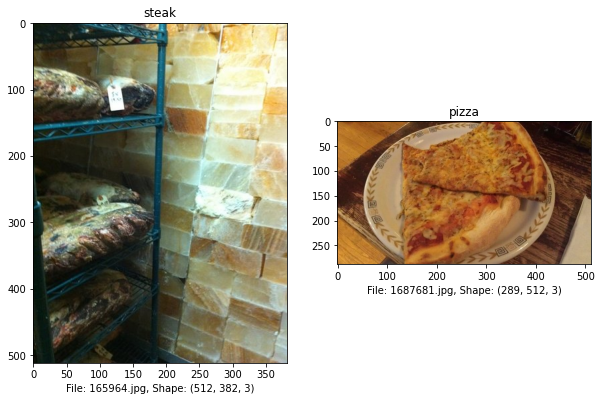

In [28]:
# Visualize the data
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
steak_img = view_random_image(train_data_dir, "steak")
plt.subplot(1, 2, 2)
pizza_img = view_random_image(train_data_dir, "pizza")

## 2. Preprocess the data (prepare it for a model)

* Turn all data into numbers
* Make sure tensors are of the right shape
* Scale/normalize features

## Our next step is to turn our data into batches

A batch is a small subset of data. Rather than look at all ~10k images, a model might only look at32ata time. 

It does this for a couple of reasons:
* 10k images might not fit into the memory of the procesor
* Trying to learn the patterns in 10k images in one hit could result in the model not being able to learn very well.

Why 32?

Because 32 is good for your health per Yann Lecun. (google yann lecun batchsize, see his twitter post). Yann Lecun is a professor at NYU



In [29]:
# See what GPU we have (if we even have one)
# !nvidia-smi

In [30]:
# Create train and test data generators and rescale the data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# When we load all the images divide all the pixel values by 255 to scale to a number between 0 and 1
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

#train_data_dir
#test_data_dir


In [31]:
#Load in our image data from directories and turn them into batches
train_data = train_datagen.flow_from_directory(
    directory=train_data_dir, # Target directory of images
    target_size=(224,224), # Target size of images
    class_mode = "binary", # type of data youre working with
    batch_size=32 # size of mini batches to load data into
)
test_data = test_datagen.flow_from_directory(
    directory=test_data_dir, 
    target_size=(224,224),
    class_mode = "binary",
    batch_size=32
)


Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [32]:
# Get a sample of train data batch
images, labels = train_data.next()
len(images), len(labels)

(32, 32)

In [33]:
# How many batches are there
len(train_data) # This equals 1500 images divided by batch size of 32, rounded up

47

In [34]:
# Get the first two images
images[:2], images[0].shape

(array([[[[0.00392157, 0.00392157, 0.01176471],
          [0.00784314, 0.00784314, 0.01568628],
          [0.00392157, 0.00392157, 0.01176471],
          ...,
          [0.        , 0.        , 0.00784314],
          [0.        , 0.        , 0.00784314],
          [0.        , 0.        , 0.00784314]],
 
         [[0.01568628, 0.01568628, 0.02352941],
          [0.02352941, 0.02352941, 0.03137255],
          [0.01568628, 0.01568628, 0.02352941],
          ...,
          [0.        , 0.        , 0.00784314],
          [0.        , 0.        , 0.00784314],
          [0.        , 0.        , 0.00784314]],
 
         [[0.01568628, 0.01568628, 0.02352941],
          [0.02745098, 0.02745098, 0.03529412],
          [0.02352941, 0.02352941, 0.03137255],
          ...,
          [0.        , 0.        , 0.00784314],
          [0.        , 0.        , 0.00784314],
          [0.        , 0.        , 0.00784314]],
 
         ...,
 
         [[0.        , 0.        , 0.00784314],
          [0.     

In [35]:
# View the first batch of labels
labels

array([1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
      dtype=float32)

# 3. Create a CNN model (start with a baseline)

A baseline is a relatively simply model or existing result that you setup when beginning a machine learning experiment. And then as you keep experimenting you try to beat the baseline.

How do you know what architecture to use? In deep learning there is almost an infinite amount of architectures you could create. So one of the best ways to get started is to start with something simple and see if it works on your data and then introduce complexity as required (e.g. look at which current model is performing best in the field for your problem)


In [36]:
# Make the creating our model a little easier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential


## Breakdown of a Conv2D layer
* Filters: Decides how many filters should pass over an input tensor (eg sliding windows over an image). Typical values are 10, 32, 64. The more filters you have, the more complex your model is.
* Kernel Size (also called filter size): Determines the shape of the filters (sliding windows) over the output. Common values are 3, 5, 7 (lower values learn smaller more fine grained features, higher values learn larger features) (i.e., lower values might identify toppings on a pizza, while a larger value might recognize the edges of a pizza)
* Padding: pads the tensor with zeroes (if "same") to preserve input shape. Or leaves the target tensor as is (if "valid"), lowering output shape. You might use padding to better learn features near the edges of your image.
* Strides: The number of steps a filter takes across an image at a time. (eg, if strides = 1, a filter moves across an image 1 pixel at a time)


In [37]:
# Create the model, this will be our baseline, a 3 layer convolutional neural network
model_4 = Sequential([
    Conv2D(
        filters=10,
        kernel_size=3,
        strides=1,
        padding="valid",
        activation="relu",
        input_shape=(224,224,3)
    ),
    Conv2D(10, 3, activation="relu"),
    Conv2D(10, 3, activation="relu"),
    Flatten(),
    Dense(1, activation="sigmoid")
])

In [38]:
# Compile the model
model_4.compile (
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# 4. Fit the model

In [39]:
# Check the lengths of training and test data generators
# The numbers this shows will be in number of batches each of 32 images
len(train_data), len(test_data)

(47, 16)

In [93]:
# Fit the model
history_4 = model_4.fit(
    train_data, # this is a combination of labels and sample data
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data)
)

Epoch 1/5
47/47 [==============================] - 33s 672ms/step - loss: 0.0552 - accuracy: 0.9873 - val_loss: 0.9074 - val_accuracy: 0.7320
Epoch 2/5
47/47 [==============================] - 30s 648ms/step - loss: 0.0517 - accuracy: 0.9900 - val_loss: 0.8525 - val_accuracy: 0.7700
Epoch 3/5
47/47 [==============================] - 29s 600ms/step - loss: 0.0123 - accuracy: 0.9980 - val_loss: 0.8891 - val_accuracy: 0.7660
Epoch 4/5
47/47 [==============================] - 20s 430ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.9229 - val_accuracy: 0.7760
Epoch 5/5
19/47 [===========>..................] - ETA: 13s - loss: 0.0011 - accuracy: 1.0000

KeyboardInterrupt: 

# 5. Evaluating our Model

It looks like our model is learning something, let's evaluate it.

* Note: When a models **validation loss** starts to increase it's likely that the model is **overfitting**. This means it's learning the patterns in the training dataset too well and thus the model's ability to generalize unseen data will be diminished.

<AxesSubplot:>

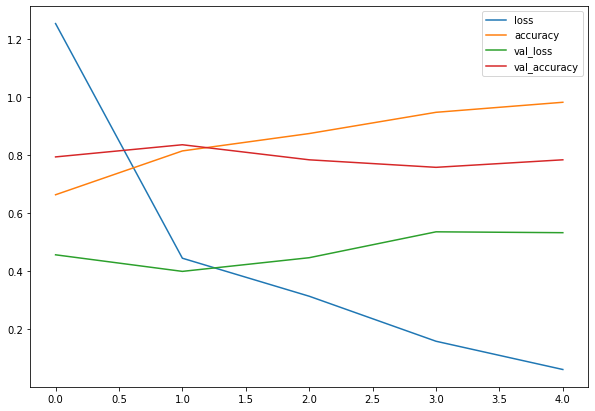

In [41]:
# Plot our loss curves
pd.DataFrame(history_4.history).plot(figsize=(10,7))

In [42]:
# Plot the validation and training curves separately
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    """
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"])) # how many epochs did we train for

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

    # Plot Accuracy
    plt.figure() #Start a new plot figure
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("accuracy")
    plt.xlabel("epochs")
    plt.legend()    



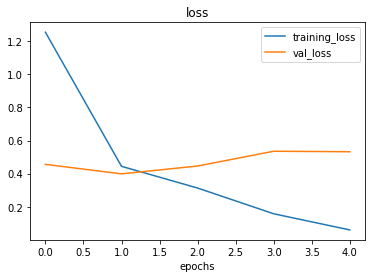

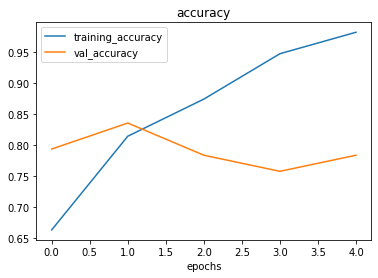

In [43]:
# Checkout the loss and accuracy of model 4
# If training loss is decreasing, but validation loss is increasing, then it shows our model is overfitting.
plot_loss_curves(history_4)

# 6. Adjust the model Parameters (Include MaxPool2D top reduce overfitting)

Fitting a machine learning model comes in 3 steps:
* 0. Create a baseline 
* 1. Beat the baseline by overfitting a larger model
* 2. Reduce overfitting

Ways to induce overfitting:
* Increase the number of conv layers
* Increase the number of conv filters
* Add another dense layer to the output of a flattened layer

Ways to Reduce overfitting:
* Add data augmentation
* Add regularization layers (such as MaxPool2D)
* Add more data

If training loss is decreasing, but validation loss is increasing, then it shows our model is overfitting. (this is what the graphs above demonstrate)

In [44]:
# Create a model (this is going to be our new baseline)
model_5 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
    MaxPool2D(pool_size=2),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

In [45]:
# Compile the model
model_5.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=Adam(),
    metrics=["accuracy"]
)

In [46]:
history_5 = model_5.fit(
    train_data,
    epochs=5,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=len(test_data)
)

Epoch 1/5
47/47 [==============================] - 4s 71ms/step - loss: 0.6533 - accuracy: 0.5978 - val_loss: 0.4578 - val_accuracy: 0.7980
Epoch 2/5
47/47 [==============================] - 3s 67ms/step - loss: 0.4776 - accuracy: 0.7740 - val_loss: 0.4221 - val_accuracy: 0.8160
Epoch 3/5
47/47 [==============================] - 3s 68ms/step - loss: 0.4320 - accuracy: 0.8003 - val_loss: 0.3711 - val_accuracy: 0.8340
Epoch 4/5
47/47 [==============================] - 3s 67ms/step - loss: 0.4172 - accuracy: 0.8254 - val_loss: 0.3434 - val_accuracy: 0.8620
Epoch 5/5
47/47 [==============================] - 3s 66ms/step - loss: 0.3796 - accuracy: 0.8439 - val_loss: 0.3532 - val_accuracy: 0.8440


In [47]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 10)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 109, 109, 10)      910       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 54, 54, 10)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 52, 52, 10)        910       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 26, 26, 10)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6760)             

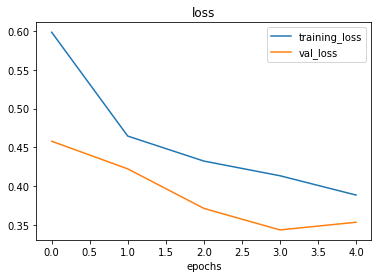

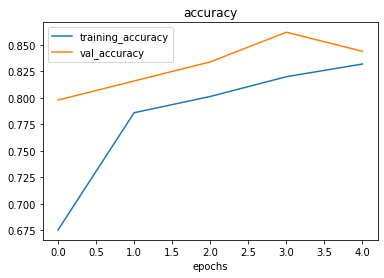

In [48]:
# See in this one that the training and validation curves are staying closer to each other
plot_loss_curves(history_5)

# Data Augmentation to Better Align the Training and Test Loss Curves

We augment the data using options to ImageDataGenerator
What is data augmentation? Data augmentation is the process of altering our training data, leading it to have more diversity and in turn allowing our models to learn more generalizable patterns. Altering might mean adjusting the rotation of an image, flipping it, or cropping it.

** Note:** Data augmentation is usually only performed on the training data. Using ImageDataGenerator built-in data augmentation parameters our images are left as they are in the directories but are mnodified as theyre loaded into the model.

Data augmentation allows us to look at the same image but from different perspectives.

In [49]:
# Create ImageDataGenerator training instance with data augmentation. 
# The augmentation applied below occurs randomly
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.2, # How much do you want to rotate an image
    shear_range=0.2, # how much do you want to shear an image
    zoom_range=0.2, # Zoom in randomly on an image
    width_shift_range=0.2, # Move yotur image around on the x axis
    height_shift_range=0.3, # Move yotur image around on the y axis
    horizontal_flip=True # Flip the image on the horizontal axis
)

# Create ImageDataGenerator without data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255
)

# Create ImageDataGenerator without data augmentation for the test dataset
test_datagen = ImageDataGenerator(
    rescale=1./255
)


In [50]:
# Lets write some code to visualize data augmentation
# Import data and augment it from training data
print("Augmented training data:")
train_data_augmented = train_datagen_augmented.flow_from_directory(
    train_data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    shuffle=False # For demonstration purposes only
)

# Create non augmented train data batches
print("Non-augmented training data:")
train_data = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    shuffle=False # For demonstration purposes only
)

# Create non augmented test data batches
print("Non-augmented test data:")
test_data = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="binary"
)



Augmented training data:
Found 1500 images belonging to 2 classes.
Non-augmented training data:
Found 1500 images belonging to 2 classes.
Non-augmented test data:
Found 500 images belonging to 2 classes.


In [51]:
# Lets visualize some augmented data
# Get some sample augmented data batches
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next()


Showing image number 16


(-0.5, 223.5, 223.5, -0.5)

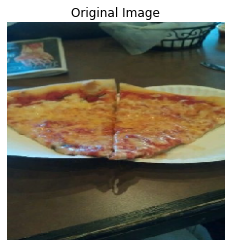

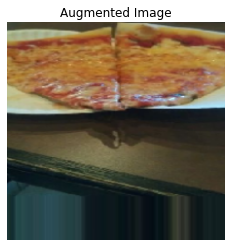

In [52]:
# Show original image and augmented image
import random
random_number = random.randint(0, 32)
print(f"Showing image number {random_number}")
plt.imshow(images[random_number])
plt.title("Original Image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title("Augmented Image")
plt.axis(False)


In [53]:
#Create a model for our augmented data
model_6 = Sequential([
    Conv2D(filters=10, kernel_size=3, activation="relu", input_shape=(224,224,3)),
    MaxPool2D(pool_size=2),
    Conv2D(filters=10, kernel_size=3, activation="relu"),
    MaxPool2D(pool_size=2),
    Conv2D(filters=10, kernel_size=3, activation="relu"),
    MaxPool2D(pool_size=2),
    Flatten(),
    Dense(1, activation="sigmoid")    
])

In [54]:
model_6.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=Adam(),
    metrics=["accuracy"]
)

In [55]:
history_6 = model_6.fit(
    train_data_augmented, 
    epochs=5,
    validation_data=test_data
)

Epoch 1/5
47/47 [==============================] - 14s 301ms/step - loss: 0.7135 - accuracy: 0.4711 - val_loss: 0.6889 - val_accuracy: 0.6080
Epoch 2/5
47/47 [==============================] - 14s 298ms/step - loss: 0.6905 - accuracy: 0.5674 - val_loss: 0.6717 - val_accuracy: 0.7260
Epoch 3/5
47/47 [==============================] - 14s 298ms/step - loss: 0.7295 - accuracy: 0.5599 - val_loss: 0.6737 - val_accuracy: 0.5100
Epoch 4/5
47/47 [==============================] - 14s 298ms/step - loss: 0.6921 - accuracy: 0.5146 - val_loss: 0.6553 - val_accuracy: 0.6980
Epoch 5/5
47/47 [==============================] - 14s 305ms/step - loss: 0.6706 - accuracy: 0.6291 - val_loss: 0.6019 - val_accuracy: 0.6940


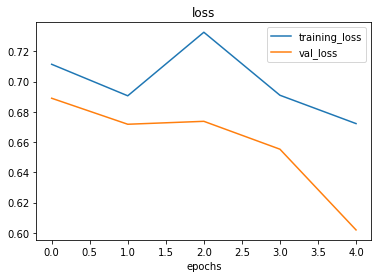

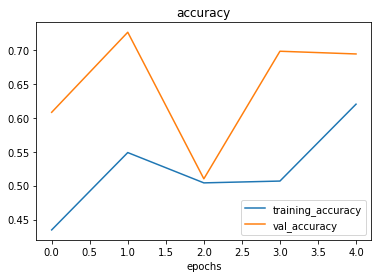

In [56]:
# Check our model training curves
plot_loss_curves(history_6)

# Shuffle Data

In the previous example the model performed poorly, with model_6 performing more poorly that model_5

Lets shuffle our augmented training data and train another model (the same as before) on it and see what happens.

In [57]:
# Import data and augment it and shuffle frokm training directory
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(
    train_data_dir,
    target_size=(224,224),
    class_mode="binary",
    batch_size=32,
    shuffle=True
)

Found 1500 images belonging to 2 classes.


In [58]:
# Create a model (same as model_5 and model_6)
model_7 = Sequential([
    Conv2D(10, 3, activation="relu", input_shape=(224,224,3)),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Conv2D(10, 3, activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(1, activation="sigmoid")
])

In [59]:
model_7.compile(
    loss=tf.keras.losses.binary_crossentropy,
    optimizer=Adam(),
    metrics=["accuracy"]
)

In [60]:
history_7 = model_7.fit(
    train_data_augmented,
    epochs=5,
    steps_per_epoch=len(train_data_augmented_shuffled),
    validation_data=test_data,
    validation_steps=len(test_data)
)

Epoch 1/5
47/47 [==============================] - 15s 305ms/step - loss: 0.7053 - accuracy: 0.4327 - val_loss: 0.6744 - val_accuracy: 0.5040
Epoch 2/5
47/47 [==============================] - 15s 330ms/step - loss: 0.6911 - accuracy: 0.4675 - val_loss: 0.6586 - val_accuracy: 0.5040
Epoch 3/5
47/47 [==============================] - 14s 308ms/step - loss: 0.6776 - accuracy: 0.5575 - val_loss: 0.6625 - val_accuracy: 0.5200
Epoch 4/5
47/47 [==============================] - 14s 297ms/step - loss: 0.6843 - accuracy: 0.5196 - val_loss: 0.6350 - val_accuracy: 0.6880
Epoch 5/5
47/47 [==============================] - 14s 299ms/step - loss: 0.6660 - accuracy: 0.6057 - val_loss: 0.6291 - val_accuracy: 0.7660


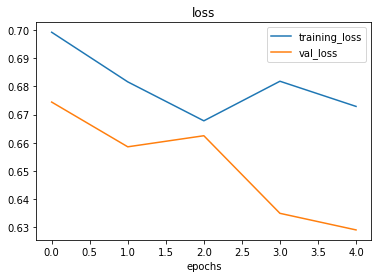

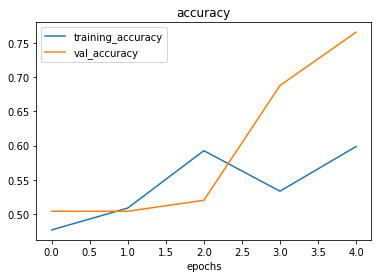

In [61]:
plot_loss_curves(history_7)

# 7. Repeat until satisfied

Since weve already beaten our baseline, there are a few things we could try to continue to improve our model:
* Increase the number of model layers (eg add more Conv2D/MaxPool2D layers)
* Increase the number of filters in each convolutional layer (eg from 10 to 32 or even 64)
* Train for longer (more epochs)
* Find an ideal learning rate
* Get more data (give the model more opportunities to learn)
* Use **transfer learning** to leverage what another model has learned and adjust it for our own use case


In [62]:
# Create ImageDataGenerator training instance with data augmentation. 
# The augmentation applied below occurs randomly
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=0.2, # How much do you want to rotate an image
    shear_range=0.2, # how much do you want to shear an image
    zoom_range=0.2, # Zoom in randomly on an image
    width_shift_range=0.2, # Move yotur image around on the x axis
    height_shift_range=0.3, # Move yotur image around on the y axis
    horizontal_flip=True # Flip the image on the horizontal axis
)

# Create ImageDataGenerator without data augmentation for the test dataset
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [67]:
# Import data and augment it and shuffle frokm training directory
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(
    train_data_dir,
    target_size=(224,224),
    class_mode="binary",
    batch_size=32,
    shuffle=True
)

test_data = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode="binary"
)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


Showing image number 4


(-0.5, 223.5, 223.5, -0.5)

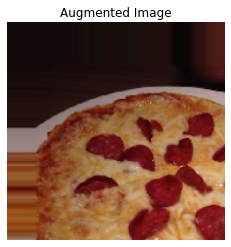

In [70]:
# Lets visualize some augmented data
# Get some sample augmented data batches
images, labels = train_data.next()
augmented_images, augmented_labels = train_data_augmented.next()

# Show a random, augmented image
import random
random_number = random.randint(0, 32)
print(f"Showing image number {random_number}")
plt.imshow(augmented_images[random_number])
plt.title("Augmented Image")
plt.axis(False)


In [71]:
# Recreate the model we used in model_1, but train it on the augmented data to see how it performs
model_8 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=3,
        activation="relu",
        #224x224 w 3 color channels
        input_shape=(224,224,3)
    ),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(
        pool_size=2,
        padding="valid"
    ),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.Conv2D(10, 3, activation="relu"),
    tf.keras.layers.MaxPool2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compile our CNN
model_8.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model
history_8 = model_8.fit(
    train_data_augmented_shuffled, 
    epochs=5, 
    steps_per_epoch=len(train_data_augmented_shuffled),
    validation_data=test_data,
    validation_steps=len(test_data)
)

Epoch 1/5
47/47 [==============================] - 585s 10s/step - loss: 0.6683 - accuracy: 0.5595 - val_loss: 0.4492 - val_accuracy: 0.7980
Epoch 2/5
47/47 [==============================] - 14s 302ms/step - loss: 0.5325 - accuracy: 0.7375 - val_loss: 0.4105 - val_accuracy: 0.8280
Epoch 3/5
47/47 [==============================] - 14s 301ms/step - loss: 0.5240 - accuracy: 0.7398 - val_loss: 0.4361 - val_accuracy: 0.7940
Epoch 4/5
47/47 [==============================] - 14s 304ms/step - loss: 0.4779 - accuracy: 0.7790 - val_loss: 0.3942 - val_accuracy: 0.8200
Epoch 5/5
47/47 [==============================] - 14s 306ms/step - loss: 0.4569 - accuracy: 0.7779 - val_loss: 0.3598 - val_accuracy: 0.8460


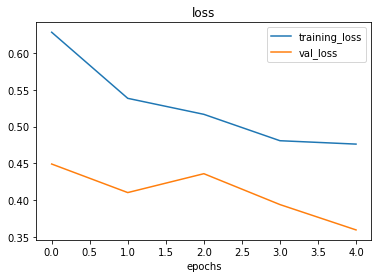

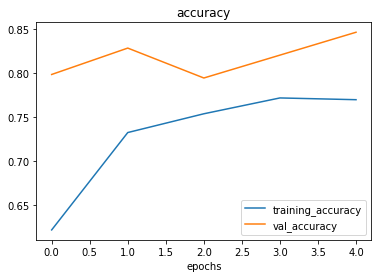

In [72]:
plot_loss_curves(history_8)

# Making a prediction with our trained model on our own custom data

When you train a neural network and you want to make a prediction with it on your own custom data, it's important that your custom data (or new data) is preprocessed into the same format as the data your model was trained on.

In [73]:
# Classes we're working with
print(class_names)


['pizza' 'steak']


In [74]:
# Create a function to import our image, and resize it to be able to be used with our model
def load_and_prep_image(url, img_shape=224):
    """
    Reads an image from filename, and turns it into a tensor and reshapes it to (img_shape, img_shape, colour_channels).
    """
    # Read in the image
    #img = tf.io.read_file(filename)
    image_request = urllib.request.urlopen(url)
    img = image_request.read()
    # Decode the read file into a tensor
    img = tf.image.decode_image(img)
    # Resize the image
    img = tf.image.resize(img, size=[img_shape, img_shape])
    # Rescale the image (get all values between 0 and 1)
    img = img/255.
    return img

(TensorShape([224, 224, 3]),
 <tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.6377451 , 0.6220588 , 0.57892156],
         [0.6504902 , 0.63186276, 0.5897059 ],
         [0.63186276, 0.60833335, 0.5612745 ],
         ...,
         [0.52156866, 0.05098039, 0.09019608],
         [0.49509802, 0.04215686, 0.07058824],
         [0.52843136, 0.07745098, 0.10490196]],
 
        [[0.6617647 , 0.6460784 , 0.6107843 ],
         [0.6387255 , 0.6230392 , 0.57598037],
         [0.65588236, 0.63235295, 0.5852941 ],
         ...,
         [0.5352941 , 0.06862745, 0.09215686],
         [0.529902  , 0.05931373, 0.09460784],
         [0.5142157 , 0.05539216, 0.08676471]],
 
        [[0.6519608 , 0.6362745 , 0.5892157 ],
         [0.6392157 , 0.6137255 , 0.56764704],
         [0.65637255, 0.6269608 , 0.5828431 ],
         ...,
         [0.53137255, 0.06470589, 0.08039216],
         [0.527451  , 0.06862745, 0.1       ],
         [0.52254903, 0.05196078, 0.0872549 ]],
 
        ...,
 
   

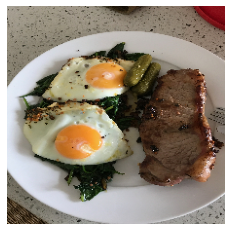

In [75]:
# Load in and preprocess our image
steak = load_and_prep_image("https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg", 224)
plt.imshow(steak)
plt.axis('off')

# Check shape of our image
steak.shape, steak

In [81]:
pred = model_8.predict(tf.expand_dims(steak, axis=0))

In [82]:
# Looks like our custom imaghe is being put through our model. However it currently outputs a prediction probability. It would be nice if we could visualize the image as well as the model's prediction.
class_names

array(['pizza', 'steak'], dtype='<U9')

In [83]:
pred_class = class_names[int(tf.round(pred))]
pred_class

'steak'

In [84]:
def pred_and_plot(model, filename, class_names=class_names):
    """
    Imports an image located at filename, makes a prediction with model, and plots the image with the predicted class as the title.
    """
    #Import the target images and preprocess it
    img = load_and_prep_image(filename)

    # Make a prediction
    pred = model.predict(tf.expand_dims(img, axis=0))

    # Get the predicted class
    pred_class = class_names[int(tf.round(pred))]

    # Plot the image and predicted class
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False)
    

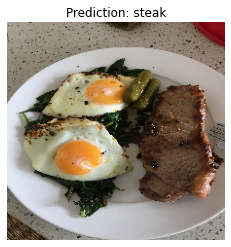

In [85]:
pred_and_plot(model_8, "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg")

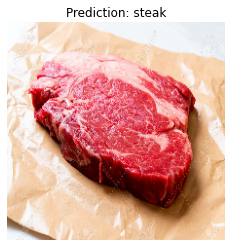

In [92]:
pred_and_plot(model_8, "https://previews.123rf.com/images/topntp/topntp1907/topntp190704628/127802337-fresh-raw-beef-steak-or-raw-meat.jpg")
